# NLP Disaster Tweets

The goal of this Kaggle project is to differentiate tweets that are describing a disaster versus those that aren't. The Kaggle competition is available here: https://www.kaggle.com/competitions/nlp-getting-started

The dataset includes approximately 10,000 tweets. Each row contains the text of the tweet, an often-empty column with the location, and the target field which is what we're trying to predict and indicates whether the tweet was about a disaster or not.

Project code for this project available here: https://github.com/blockee/cu-deep/tree/main/disaster

### Setup and Data Reading

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

In [ ]:
def pandas_to_dataset(df, text_column, target_column, batch_size=64):
  """Converts a Pandas DataFrame with one text input column + target column
   to a TensorFlow Dataset."""

  texts = df[text_column].values

  if target_column is None:
    dataset = tf.data.Dataset.from_tensor_slices((texts))
  else:
    labels = df[target_column].astype(int).values
    dataset = tf.data.Dataset.from_tensor_slices((texts, labels))

  dataset = dataset.batch(batch_size)
  return dataset

In [ ]:
initial_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')
print(initial_df.shape)
initial_df.head()

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Exploratory Data Analysis

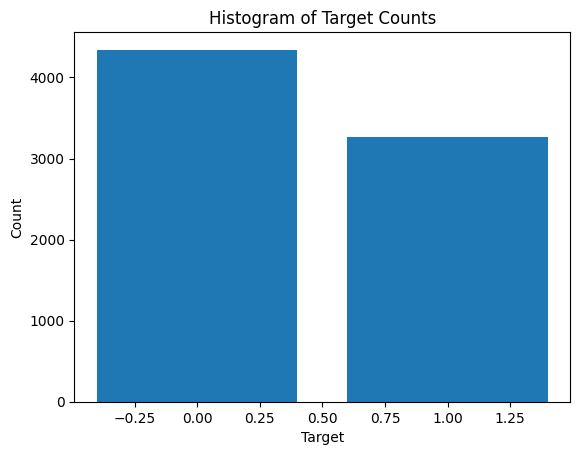

In [ ]:
category_counts = initial_df['target'].value_counts()
# Create the histogram
plt.bar(category_counts.index, category_counts.values)
# Add labels and title
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Histogram of Target Counts')
# Show the plot
plt.show()

In [ ]:
 initial_df['text_len'] = initial_df["text"].apply(len)

In [ ]:
initial_df.describe()

,id,target,text_len
count,7613.000000,7613.00000,7613.000000
mean,5441.934848,0.42966,101.037436
std,3137.116090,0.49506,33.781325
min,1.000000,0.00000,7.000000
25%,2734.000000,0.00000,78.000000
50%,5408.000000,0.00000,107.000000
75%,8146.000000,1.00000,133.000000
max,10873.000000,1.00000,157.000000


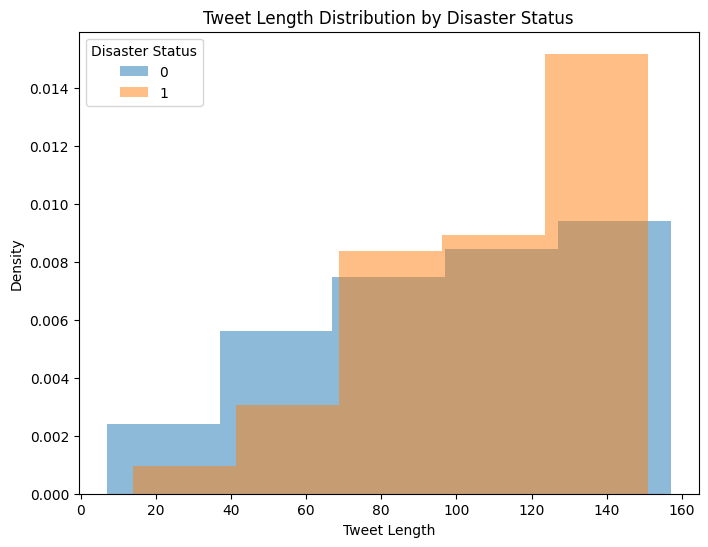

In [ ]:
grouped = initial_df.groupby('target')
# Plot histograms for each category
plt.figure(figsize=(8, 6))
for name, group in grouped:
  plt.hist(group['text_len'], bins=5, alpha=0.5, label=name, density=True)
plt.xlabel('Tweet Length')
plt.ylabel('Density')
plt.title('Tweet Length Distribution by Disaster Status')
plt.legend(title='Disaster Status')
plt.show()

Tweets about disasters do tend to be longer than non-disaster tweets and there's a slight imbalance in the dataset but nothing that requires extra measures in my opinion - especially considering that we don't have very much training data to begin with. I wouldn't want to downsample and lose training examples.

### Dataset Prep and Initial Model Creation

In [ ]:
train_df, valid_df = train_test_split(initial_df, test_size=0.2, random_state=121, stratify=initial_df.target)

print(train_df.shape)
print(valid_df.shape)

(6090, 5)
(1523, 5)


In [ ]:
train_tf = pandas_to_dataset(train_df, 'text', 'target')
valid_tf = pandas_to_dataset(valid_df, 'text', 'target')
test_tf = pandas_to_dataset(test_df, 'text', None)

In [ ]:
example, label = next(iter(train_tf))
print('Text:\n', example.numpy()[0])
print('\nLabel: ', label.numpy()[0])

Text:
 b'Julie + R is the apocalypse version of Romeo + Juliet #warmbodies'

Label:  0


In [ ]:
encoder = tf.keras.layers.TextVectorization(max_tokens=10000)
encoder.adapt(train_tf.map(lambda text, _: text))

# Extracting the vocabulary from the TextVectorization layer.
vocabulary = np.array(encoder.get_vocabulary())

# Encoding a test example and decoding it back.
original_text = example.numpy()[0]
encoded_text = encoder(original_text).numpy()
decoded_text = ' '.join(vocabulary[encoded_text])

print('original: ', original_text)
print('encoded: ', encoded_text)
print('decoded: ', decoded_text)

original:  b'Julie + R is the apocalypse version of Romeo + Juliet #warmbodies'
encoded:  [3426  897    9    2  650 1154    6 8363    1 6426]
decoded:  julie r is the apocalypse version of romeo [UNK] warmbodies


In [ ]:
len(encoder.get_vocabulary())

10000

I've decided to create a straightforward LSTM model to set the baseline for this task. The dataset is fairly small so I want to start with a simple model architecture. The memory component of the LSTM layers are well-suited to the task of putting words in context with one another to determine whether or not the text pertains to a disaster.

In [ ]:
# Creating the model
model = tf.keras.Sequential([
	tf.keras.Input(shape=(1,), dtype=tf.string),
  encoder,
	tf.keras.layers.Embedding(
		len(encoder.get_vocabulary()), 64, mask_zero=True),
	tf.keras.layers.Bidirectional(
		tf.keras.layers.LSTM(64, return_sequences=True)),
	tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
	tf.keras.layers.Dense(64, activation='relu'),
	tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# Summary of the model
model.summary()

# Compile the model
model.compile(
	loss=tf.keras.losses.BinaryCrossentropy(),
	optimizer=tf.keras.optimizers.Adam(),
	metrics=['accuracy']
)

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_5                 │ (None, None)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_16 (Embedding)             │ (None, None, 64)            │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_12 (Bidirectional)     │ (None, None, 128)           │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_13 (Bidirectional)     │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 431,489 (1.65 MB)

 Trainable params: 431,489 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the model and validating it on test set
history = model.fit(
	train_tf,
	epochs=5,
	validation_data=valid_tf,
)

Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 126ms/step - accuracy: 0.6336 - loss: 0.6239 - val_accuracy: 0.7669 - val_loss: 0.5034
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.8485 - loss: 0.3699 - val_accuracy: 0.7669 - val_loss: 0.5153
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.8937 - loss: 0.2744 - val_accuracy: 0.7577 - val_loss: 0.6293
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.9221 - loss: 0.2150 - val_accuracy: 0.7577 - val_loss: 0.7288
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - accuracy: 0.9400 - loss: 0.1706 - val_accuracy: 0.7485 - val_loss: 0.6917


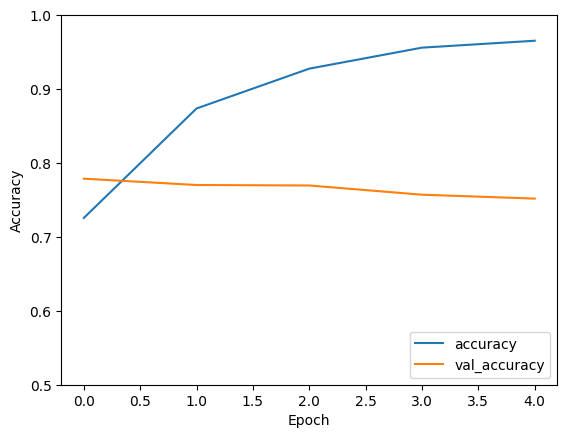

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
test_pred = model.predict(test_tf)
test_pred = test_pred.reshape(-1)
test_pred.shape

51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step


(3263,)

In [ ]:
test_pred

array([0.56881297, 0.13576531, 0.994531  , ..., 0.97534287, 0.9398776 ,
       0.9872991 ], dtype=float32)

In [ ]:
test_df['target'] = test_pred
submit_df = test_df[['id', 'target']]
submit_df = submit_df.round()
submit_df.to_csv('/content/submission-initial.csv', index=False)

### Simpler GRU Model with Dropout

The first model I tried quickly overfit the data wo I'm adding in a dropout layer after the dense layer and also trying Gated Recurrent Units rather than LSTM units. GRU is a simpler architecture and is appropriate when the task doesn't require memory for long sequences. Given that we're working with tweets, that seems appropriate.

In [ ]:
# Creating the model
model = tf.keras.Sequential([
	tf.keras.Input(shape=(1,), dtype=tf.string),
  encoder,
	tf.keras.layers.Embedding(
		len(encoder.get_vocabulary()), 64, mask_zero=True),
	tf.keras.layers.GRU(units=64, return_sequences=True),
    tf.keras.layers.GRU(units=64),
	tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.35),
	tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# Summary of the model
model.summary()

# Adding Early Stopping
callback = EarlyStopping(monitor='val_accuracy',
                         patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

# Compile the model
model.compile(
	loss=tf.keras.losses.BinaryCrossentropy(),
	optimizer=tf.keras.optimizers.Adam(),
	metrics=['accuracy']
)

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_3                 │ (None, None)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_14 (Embedding)             │ (None, None, 64)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_14 (GRU)                         │ (None, None, 64)            │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_15 (GRU)                         │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 694,145 (2.65 MB)

 Trainable params: 694,145 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the model and validating it on test set
history = model.fit(
	train_tf,
	epochs=5,
	validation_data=valid_tf,
  callbacks=[callback]
)

Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - accuracy: 0.6109 - loss: 0.6494 - val_accuracy: 0.7807 - val_loss: 0.4831
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.8496 - loss: 0.3718 - val_accuracy: 0.7708 - val_loss: 0.5240


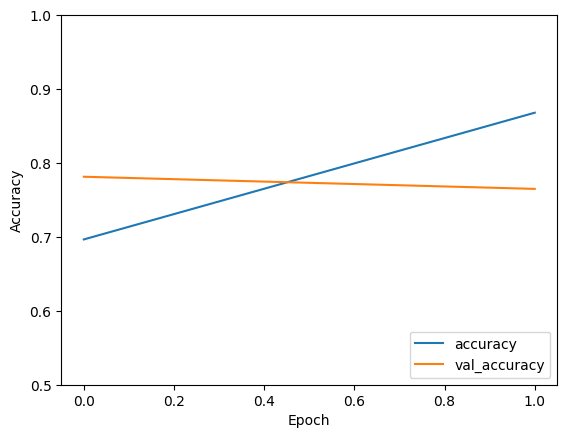

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
test_pred = model.predict(test_tf)
test_pred = test_pred.reshape(-1)
test_pred.shape

51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step


(3263,)

In [ ]:
test_df['target'] = test_pred
submit_df = test_df[['id', 'target']]
submit_df = submit_df.round()
submit_df.to_csv('/content/submission-gru-early.csv', index=False)

I added early stopping in anticipation of some overfitting and that was the case again. This model also didn't pass the scoring threshold.

# Adding Regularization and Dropout

In an effort to reduce overfitting, I've added regularization to the dense layer and added dropout and recurrent dropout to the bidirectional layers.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),

    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)),

    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(32, dropout=0.3, recurrent_dropout=0.2)),

    tf.keras.layers.Dense(64, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(0.01)),

    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])



# Summary of the model
model.summary()

# Compile the model
model.compile(
	loss=tf.keras.losses.BinaryCrossentropy(),
	optimizer=tf.keras.optimizers.Adam(),
	metrics=['accuracy']
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, None, 64)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 128)      │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 751,489 (2.87 MB)

 Trainable params: 751,489 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
	train_tf,
	epochs=10,
	validation_data=valid_tf,
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 260ms/step - accuracy: 0.5985 - loss: 1.1418 - val_accuracy: 0.7827 - val_loss: 0.6673
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 235ms/step - accuracy: 0.8387 - loss: 0.5431 - val_accuracy: 0.7827 - val_loss: 0.5818
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 22s 229ms/step - accuracy: 0.9049 - loss: 0.3054 - val_accuracy: 0.7735 - val_loss: 0.6175
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 22s 229ms/step - accuracy: 0.9381 - loss: 0.2058 - val_accuracy: 0.7676 - val_loss: 0.7005
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 22s 231ms/step - accuracy: 0.9511 - loss: 0.1688 - val_accuracy: 0.7538 - val_loss: 0.7056
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 239ms/step - accuracy: 0.9627 - loss: 0.1297 - val_accuracy: 0.7590 - val_loss: 0.7524
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 22s 234ms/step - accuracy: 0.9688 - loss: 0.1097 - val_accuracy: 0.7551 - val_loss: 0.8599
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 234ms/step - accuracy: 0.9760 - loss: 0.0865 - val_accu

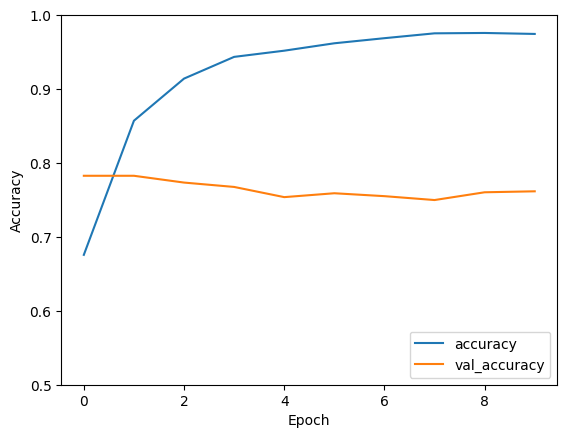

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
test_pred = model.predict(test_tf)
test_pred = test_pred.reshape(-1)
test_pred.shape

51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step


(3263,)

In [ ]:
test_df['target'] = test_pred
submit_df = test_df[['id', 'target']]
submit_df = submit_df.round()
submit_df.to_csv('/content/submission-reg-dropout.csv', index=False)

### Regularization and Dropout with Early Stopping

In [ ]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),

    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)),

    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(32, dropout=0.3, recurrent_dropout=0.2)),

    tf.keras.layers.Dense(64, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(0.01)),

    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Summary of the model
model.summary()

# Adding Early Stopping
callback = EarlyStopping(monitor='val_accuracy',
                         patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

# Compile the model
model.compile(
	loss=tf.keras.losses.BinaryCrossentropy(),
	optimizer=tf.keras.optimizers.Adam(),
	metrics=['accuracy']
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, None, 64)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, None, 128)      │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 751,489 (2.87 MB)

 Trainable params: 751,489 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the model and validating it on test set
history = model.fit(
	train_tf,
	epochs=5,
	validation_data=valid_tf,
  callbacks=[callback]
)

Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 39s 255ms/step - accuracy: 0.6128 - loss: 1.1299 - val_accuracy: 0.7846 - val_loss: 0.6582
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 238ms/step - accuracy: 0.8413 - loss: 0.5190 - val_accuracy: 0.7807 - val_loss: 0.5476


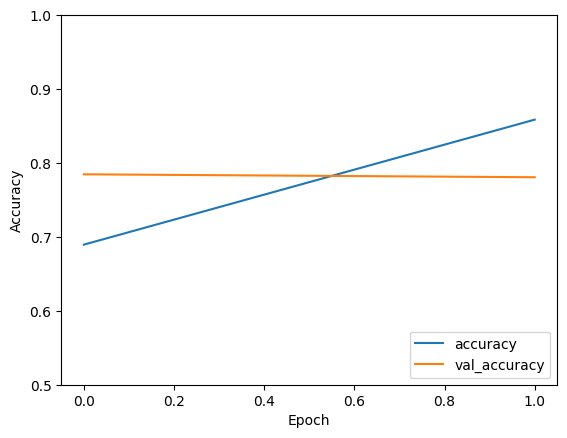

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
test_pred = model.predict(test_tf)
test_pred = test_pred.reshape(-1)
test_pred.shape

51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step


(3263,)

In [ ]:
test_df['target'] = test_pred
submit_df = test_df[['id', 'target']]
submit_df = submit_df.round()
submit_df.to_csv('/content/submission-reg-dropout-early.csv', index=False)

# Pretrained Network Approach

The various iterations of recurrent neural networks that I've created and trained have all failed to beat the scoring threshold for this task, unfortunately. Here, I go with a different approach and use a pretrained network for the task. Below, I bring the "BertForSequenceClassification" model into the environment and train it for just one epoch on this classification task.

In [ ]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_data(df, tokenizer):
    return tokenizer(df['text'].tolist(), padding=True, truncation=True, max_length=128, return_tensors="pt")

# Encode the data
train_encodings = tokenize_data(train_df, tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
class TweetDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    evaluation_strategy="epoch"
)

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Tokenize both training and validation data
train_encodings = tokenize_data(train_df, tokenizer)
val_encodings = tokenize_data(valid_df, tokenizer)

# Create datasets
train_dataset = TweetDataset(train_encodings, train_df['target'].values)
val_dataset = TweetDataset(val_encodings, valid_df['target'].values)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  # Adding the validation dataset here
    compute_metrics=lambda p: {'accuracy': (np.argmax(p.predictions, axis=1) == p.label_ids).mean()}
)

In [ ]:
trainer.train()

<ipython-input-11-ec98418e07fc>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy
1,0.473400,0.439386,0.813526


<ipython-input-11-ec98418e07fc>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


TrainOutput(global_step=191, training_loss=0.5455501416590826, metrics={'train_runtime': 5738.2009, 'train_samples_per_second': 1.061, 'train_steps_per_second': 0.033, 'total_flos': 262884944296800.0, 'train_loss': 0.5455501416590826, 'epoch': 1.0})

In [ ]:
test_encodings = tokenize_data(test_df, tokenizer)
test_dataset = TweetDataset(test_encodings)
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Create a submission DataFrame
submission = pd.DataFrame({
    'id': test_df['id'],
    'target': predicted_labels
})

<ipython-input-11-ec98418e07fc>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [ ]:
submission.to_csv('pretrained-submission.csv', index=False)

### Results and Analysis

Overall, the various RNN architectures that I tried were not successful in this competition. Even with regularization and dropout, the models began to overfit after just a few epochs. I wonder if there are not enough records in the training set for the neural network to learn general patterns rather than just memorizing the answers for that specifi dataset.

The pretrained network was significantly more effective, even with just one training epoch on this specific task. The pretrained network begins with an ability to detect general language patterns, unlike the from-scratch recurrent models which all seem to be memorizing training-data-specific patterns that don't generalize particularly well.

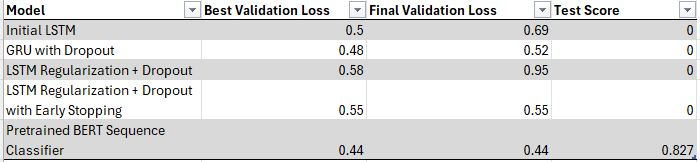

### Conclusion

It was disappointing to have my efforts in making from-scratch networks be unsuccessful. I believe that I identified the right issue - overfitting - but the approaches that I took to fix it didn't end up helping. I think that's in part because the dataset is only about 10,000 examples. That's as small as it gets for deep learning techniques.

If I were to continue working on this problem, I'd put my next efforts into a more traditional NLP approach and spend more time preprocessing the texts. Another fruitful path might be to train the pretrained network over more epochs and/or compare other pretrained networks. Pretrained networks allow us to apply the learnings from much larger datasets to custom tasks like this and are an amazing innovation and a testament to the power of open source tools.

### References

Hugging Face Text Classification guide: https://huggingface.co/docs/transformers/en/tasks/sequence_classification

BERT Classifier: https://huggingface.co/docs/transformers/en/model_doc/bert#transformers.BertForSequenceClassification

Tensorflow Embedding Layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding